### 传热正向计算

对于稳态传热，研究具有角方向对称性的密封环，使用PINN方法，并将结果与有限元进行对比

In [1]:
from math import pi as PI
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os
import ast
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

from PINN.diff import diff
from PINN.networks import FCNN,Resnet
from PINN.generators import generator_2dspatial_rectangle, generator_2dspatial_segment
from PINN.conditions import BoundaryCondition
from PINN.solvers import SingleNetworkApproximator2DSpatial
from PINN.monitors import Monitor2DSpatial
from PINN.solvers import _solve_2dspatial


In [2]:
r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

h=20602.3271 #对流换热系数、
#h=200
T0=303.15 #外界温度
k=60 #传热系数
maxf=10 #端面最高温度



parser = argparse.ArgumentParser(description='PyTorch Deep Learning Training Heat Forward')

# 添加命令行参数
parser.add_argument('--lr', type=float, default=0.0003, help='学习率')
parser.add_argument('--batch_size', type=int, default=1024, help='批量大小')
parser.add_argument('--epochs', type=int, default=1000000, help='训练轮数')
parser.add_argument('--gpu', type=bool , default=False ,help='使用GPU进行训练')
parser.add_argument('--train_rec_size', type=int , default=128 ,help='矩形区域内生成的点,512*512')
parser.add_argument('--train_bound_size', type=int , default=64 ,help='边界上生成的点数')
parser.add_argument('--train_gen_random', type=bool , default=True ,help='训练生成点是否随机')
parser.add_argument('--valid_gen_random', type=bool , default=True ,help='验证生成点是否随机')
parser.add_argument('--weight_equ1', type=int , default=1 ,help='方程权重')
parser.add_argument('--weight_equ2', type=int , default=5 ,help='方程权重')  #left
parser.add_argument('--weight_equ3', type=int , default=2 ,help='方程权重')  #bottom
parser.add_argument('--weight_equ4', type=int , default=5 ,help='方程权重') #right
parser.add_argument('--weight_equ5', type=int , default=200 ,help='方程权重') #right
parser.add_argument('--weight_equ6', type=int , default=20 ,help='方程权重') #right

parser.add_argument('--equ', type=int , default=1 ,help='方程权重')
parser.add_argument('--weight_up', type=int , default=1 ,help='上边界权重')
parser.add_argument('--weight_left', type=int , default=1 ,help='左边界权重')
parser.add_argument('--weight_right', type=int , default=1 ,help='右边界权重')
parser.add_argument('--weight_bottom', type=int , default=1 ,help='下边界权重')
parser.add_argument('--boundary_strictness', type=int , default=30 ,help='边界严格参数')
parser.add_argument('--center_value', type=int , default=1 ,help='边界严格参数')
parser.add_argument('--network_MLP', type=str , default="32,32,32,32,32" ,help='全连接网络形状')
parser.add_argument('--check_every', type=int , default=1000 ,help='检测周期')
parser.add_argument('--save_dict', type=str , default='run5' ,help='训练文件名')
parser.add_argument('--maxf', type=int , default=10 ,help='端面相对温度最大值')
parser.add_argument('--impose', type=int , default=1 ,help='是否强加Drichlet边界,1为施加')
parser.add_argument('--mtl', type=int , default=0 ,help='是否使用多任务权重学习,1为使用')
parser.add_argument('--left_num', type=int , default=3 ,help='左边界生成点数')



args = parser.parse_args(args=[])
print(args)

save_image_folder = args.save_dict + "-image/"
save_model_folder=args.save_dict + "-model/"

# 确保文件夹存在，如果不存在则创建
if not os.path.exists(save_image_folder):
    os.makedirs(save_image_folder)
if not os.path.exists(save_model_folder):
    os.makedirs(save_model_folder)


heat_fem=pd.read_csv('./data/heat.txt',delimiter=r'\s+')

Namespace(lr=0.0003, batch_size=1024, epochs=1000000, gpu=False, train_rec_size=128, train_bound_size=64, train_gen_random=True, valid_gen_random=True, weight_equ1=1, weight_equ2=5, weight_equ3=2, weight_equ4=5, weight_equ5=200, weight_equ6=20, equ=1, weight_up=1, weight_left=1, weight_right=1, weight_bottom=1, boundary_strictness=30, center_value=1, network_MLP='32,32,32,32,32', check_every=1000, save_dict='run5', maxf=10, impose=1, mtl=0, left_num=3)


/Users/yst/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


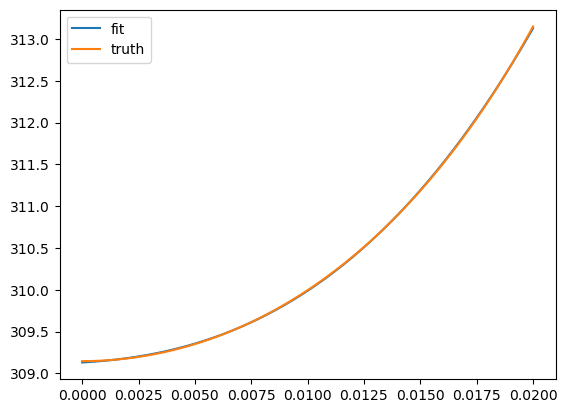

In [3]:
# 定义要拟合的高阶多项式函数
def func(x, *coefficients):
    return sum(coefficients[i] * x**i for i in range(len(coefficients)))

# 假设你有一行 x 值和一行 y 值
z_data = np.array((heat_fem['Z'])).reshape(400,400)[0,:]
t_data = np.array((heat_fem['T'])).reshape(400,400)[0,:]

# 使用 curve_fit 函数拟合
degree = 5  # 3次多项式拟合
popt, pcov = curve_fit(func, z_data, t_data, p0=np.zeros(degree + 1))

# popt 包含了拟合后的参数
coefficients_fit = popt
# 生成拟合的 y 值
y_fit = func(z_data, *coefficients_fit)
plt.plot(z_data,y_fit,label='fit')
plt.plot(z_data,t_data,label='truth')
plt.legend()
plt.show()

In [4]:
use_gpu = args.gpu
device = torch.device("mps" if use_gpu else "cpu")
if use_gpu:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        
size_train=args.train_rec_size


def heat_transfer(u , xx, yy):
    return diff(u, xx, order=2) + diff(u, yy, order=2)

def heat_transfer_norm(u,xx,yy):
    #return (diff(u,yy,order=2)+diff(u,xx,order=2)/(r2-r1)/(r2-r1)*h1*h1+diff(u,xx)/(xx*(r2-r1)*(r2-r1)+r1*(r2-r1))*h1*h1)
    return diff(u,xx)+((r2-r1)*xx+r1)/(r2-r1)*diff(u,xx,order=2)+((r2-r1)*xx+r1)*(r2-r1)/h1/h1*diff(u,yy,order=2)

def left(u,xx,yy):
    return diff(u,xx)

def bottom(u,xx,yy):
    return diff(u,yy)

def right(u,xx,yy):
    return (r2-r1)*h/k*u+diff(u,xx)

def left_data(u,xx,yy):
    test_point_z=torch.linspace(0,h1,args.left_num).to(device)
    test_point_z=test_point_z[1:len(test_point_z)-1]
    truth=func(test_point_z, *coefficients_fit)
    test_point_z=test_point_z/h1
    test_point_r=((torch.linspace(r1,r1,args.left_num)-r1)/(r2-r1)).to(device)
    
    test_point_r=test_point_r[1:len(test_point_r)-1]
    predict=fcnn_approximator.__call__(test_point_r.requires_grad_(),test_point_z.requires_grad_())
    
    return predict[:,0]-(truth-303.15)/10

def continue_condition(u,xx,yy):
    point_z=[1.0]
    point_r=[1.0]
    point_z=torch.tensor(point_z).to(device)
    point_r=torch.tensor(point_r).to(device)
    point_T=fcnn_approximator.__call__(point_r.requires_grad_(),point_z.requires_grad_())
    
    return diff(point_T[:,0],point_r)

#left
adiabatic_left=BoundaryCondition(
    form=lambda u, x, y: diff(u,x),
    
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(0.0, 1.0),device=device),
    weight=args.weight_left,
    impose=0
)
#bottom
adiabatic_bottom=BoundaryCondition(
    form=lambda u, x, y: diff(u,y),
    #form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 0.0), end=(1.0, 0.0),device=device),
    weight=args.weight_bottom,
    impose=0
)
#right
convection_externel=BoundaryCondition(

    form=lambda u, x, y: (r2-r1)*h/k*u+diff(u,x),
    #form=lambda u, x, y: u+k/(r2-r1)*diff(u,x)/h,
    
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(1.0, 0.0), end=(1.0, 1.0),device=device),
    #weight=1/h/h/3
    weight=args.weight_right,
    impose=0
)
#up
constant_interface=BoundaryCondition(
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2)-1,
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2),
    form=lambda u, x, y: u-(2*x*x*x-3*x*x+1),
    points_generator=generator_2dspatial_segment(size=args.train_bound_size, start=(0.0, 1.0), end=(1.0, 1.0),device=device,random=True),
    weight=args.weight_up,
    impose=args.impose
)

#观测各个边界以及方程的损失
metrics={}
#方程
def pdemse(uu,xx,yy):
    error=heat_transfer_norm(uu[:,0],xx,yy)
    return torch.mean(abs(error)**2)
metrics['pdemse']=pdemse

#左边界
def leftbound_mse(uu,xx,yy):
    x,y=next(adiabatic_left.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=adiabatic_left.form(u[:,0],x,y)
    return torch.mean(abs(error)**2)
metrics['leftbound_mse']=leftbound_mse

#下边界
def bottombound_mse(uu,xx,yy):
    x,y=next(adiabatic_bottom.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=adiabatic_bottom.form(u[:,0],x,y)
    return torch.mean(abs(error)**2)
metrics['bottombound_mse']=bottombound_mse

#右边界
def rightbound_mse(uu,xx,yy):
    x,y=next(convection_externel.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=convection_externel.form(u[:,0],x,y)
    return torch.mean(abs(error)**2)
metrics['rightbound_mse']=rightbound_mse
    
#上边界
def upbound_mse(uu,xx,yy):
    x,y=next(constant_interface.points_generator)
    u=fcnn_approximator.__call__(x.requires_grad_(),y.requires_grad_())
    error=constant_interface.form(u[:,0],x,y)
    return torch.mean(abs(error)**2)
metrics['upbound_mse']=upbound_mse

#左边界真值
def left_data_mse(uu,xx,yy):
    error=left_data(uu,xx,yy)
    return torch.mean(abs(error)**2)
metrics['left_data_mse']=left_data_mse

def continue_condition_mse(uu,xx,yy):
    error=continue_condition(uu,xx,yy)
    return torch.mean(abs(error)**2)
metrics['continue_condition_mse']=continue_condition_mse

# 与comsol对比mse
def comsol_compare(uu,xx,yy):
    x=torch.linspace(0.0, 1.0, 50).requires_grad_()
    y=torch.linspace(0.0, 1.0, 50).requires_grad_()
    xy_tensor = torch.cartesian_prod(x, y).to(device)
            
    xx = torch.squeeze(xy_tensor[:, 0])
    yy = torch.squeeze(xy_tensor[:, 1])

    uu=fcnn_approximator.__call__(xx,yy)
    uu=uu.detach().cpu().numpy()
    fem=pd.read_csv('./data/h20000.txt',delimiter=r'\s+')
    #fem=pd.read_csv('./data/D_4.txt',delimiter=r'\s+')
    uu_di=abs(uu[:,0]*args.maxf+303.15-fem['T'].values)
    return np.mean(uu_di **2 )


metrics['comsol_compare']=comsol_compare

    

#pureLoss
# def pureloss(uu,xx,yy):
#     return pdemse(uu,xx,yy)+rightbound_mse(uu,xx,yy)+bottombound_mse(uu,xx,yy)+leftbound_mse(uu,xx,yy)+upbound_mse(uu,xx,yy)
# metrics['pureloss']=pureloss


        

fcnn = FCNN(
    n_input_units=2,
    n_output_units=4,
    hidden_units=ast.literal_eval(args.network_MLP),
    #hidden_units=(32,32),
    #actv=nn.Softplus
    #actv=nn.ReLU
    actv=nn.Tanh
)

fcnn=fcnn.to(device)


fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    #single_network=renn,
    pde=(heat_transfer_norm,left,bottom,right,continue_condition),#continue_condition
    boundary_conditions=[
        adiabatic_left,
        adiabatic_bottom,
        convection_externel,
        constant_interface
    ],
    boundary_strictness=args.boundary_strictness,
    args=args
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=args.lr)
train_gen_spatial = generator_2dspatial_rectangle(size=(size_train, size_train), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0,device=device,random=args.train_gen_random,bound=True)
valid_gen_spatial = generator_2dspatial_rectangle(size=(50, 50), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=args.valid_gen_random,device=device)

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

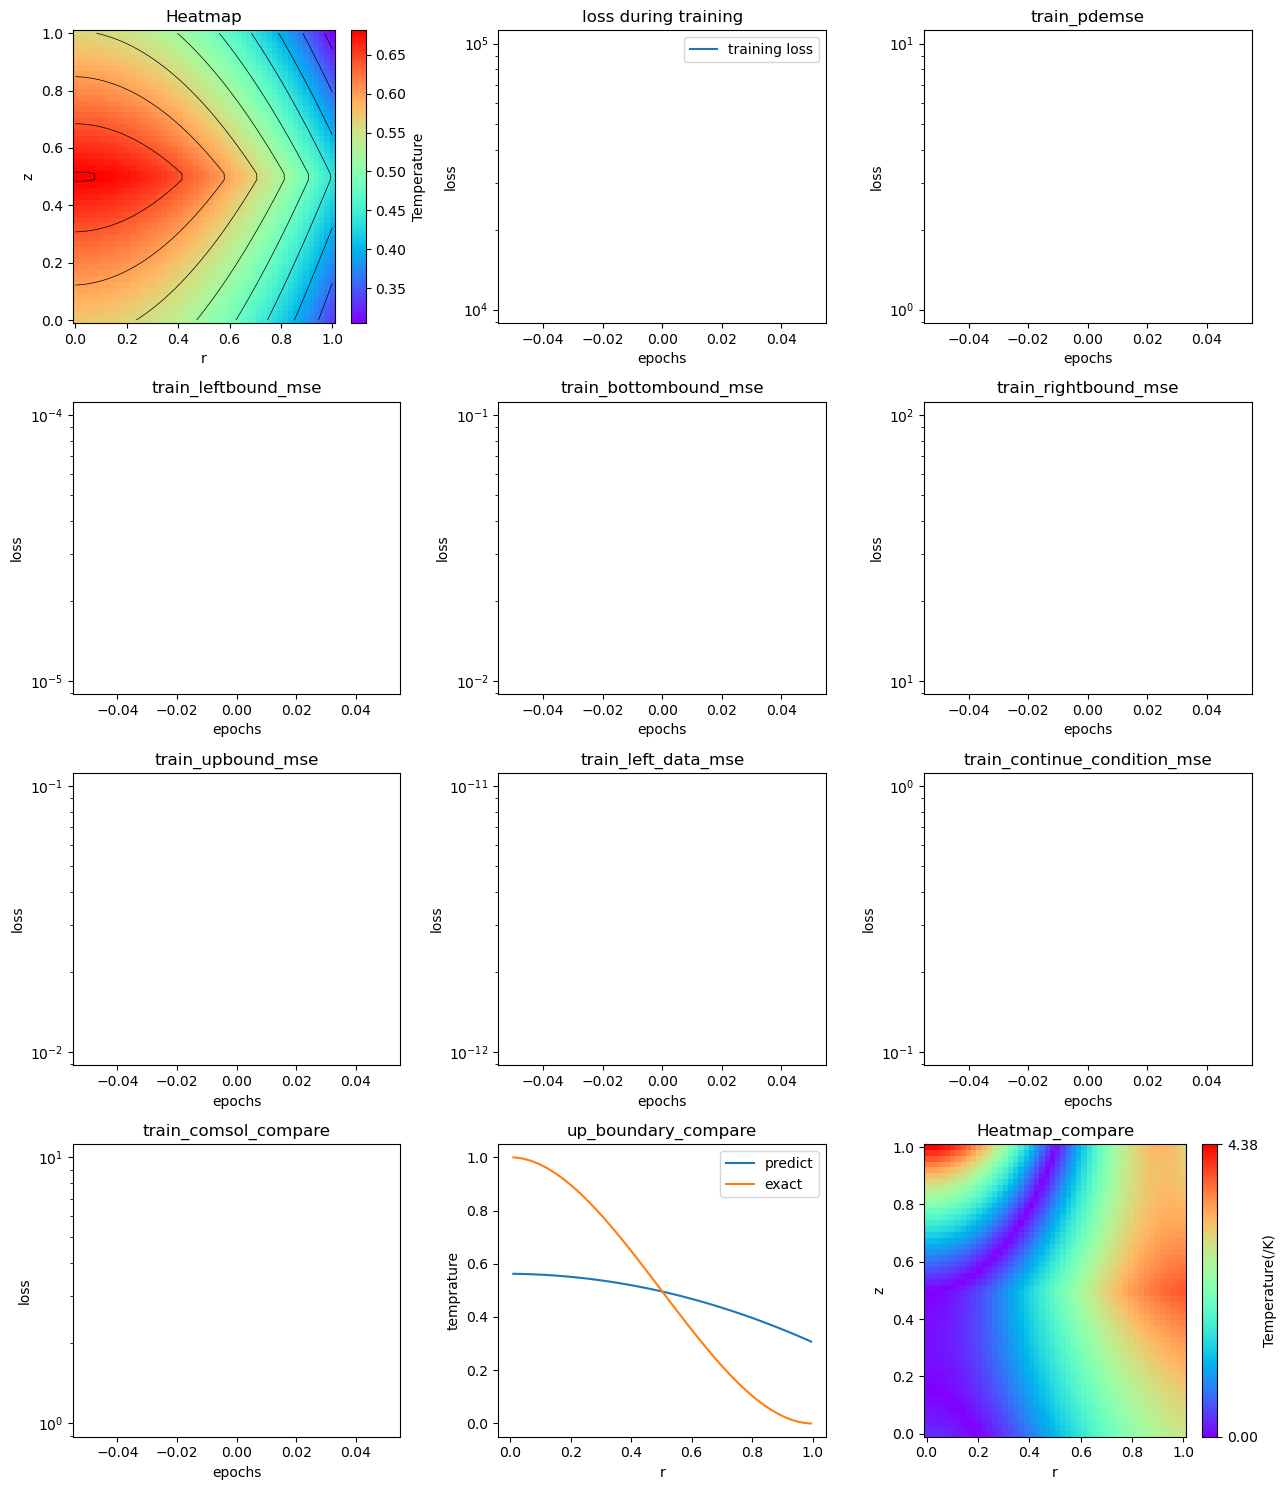

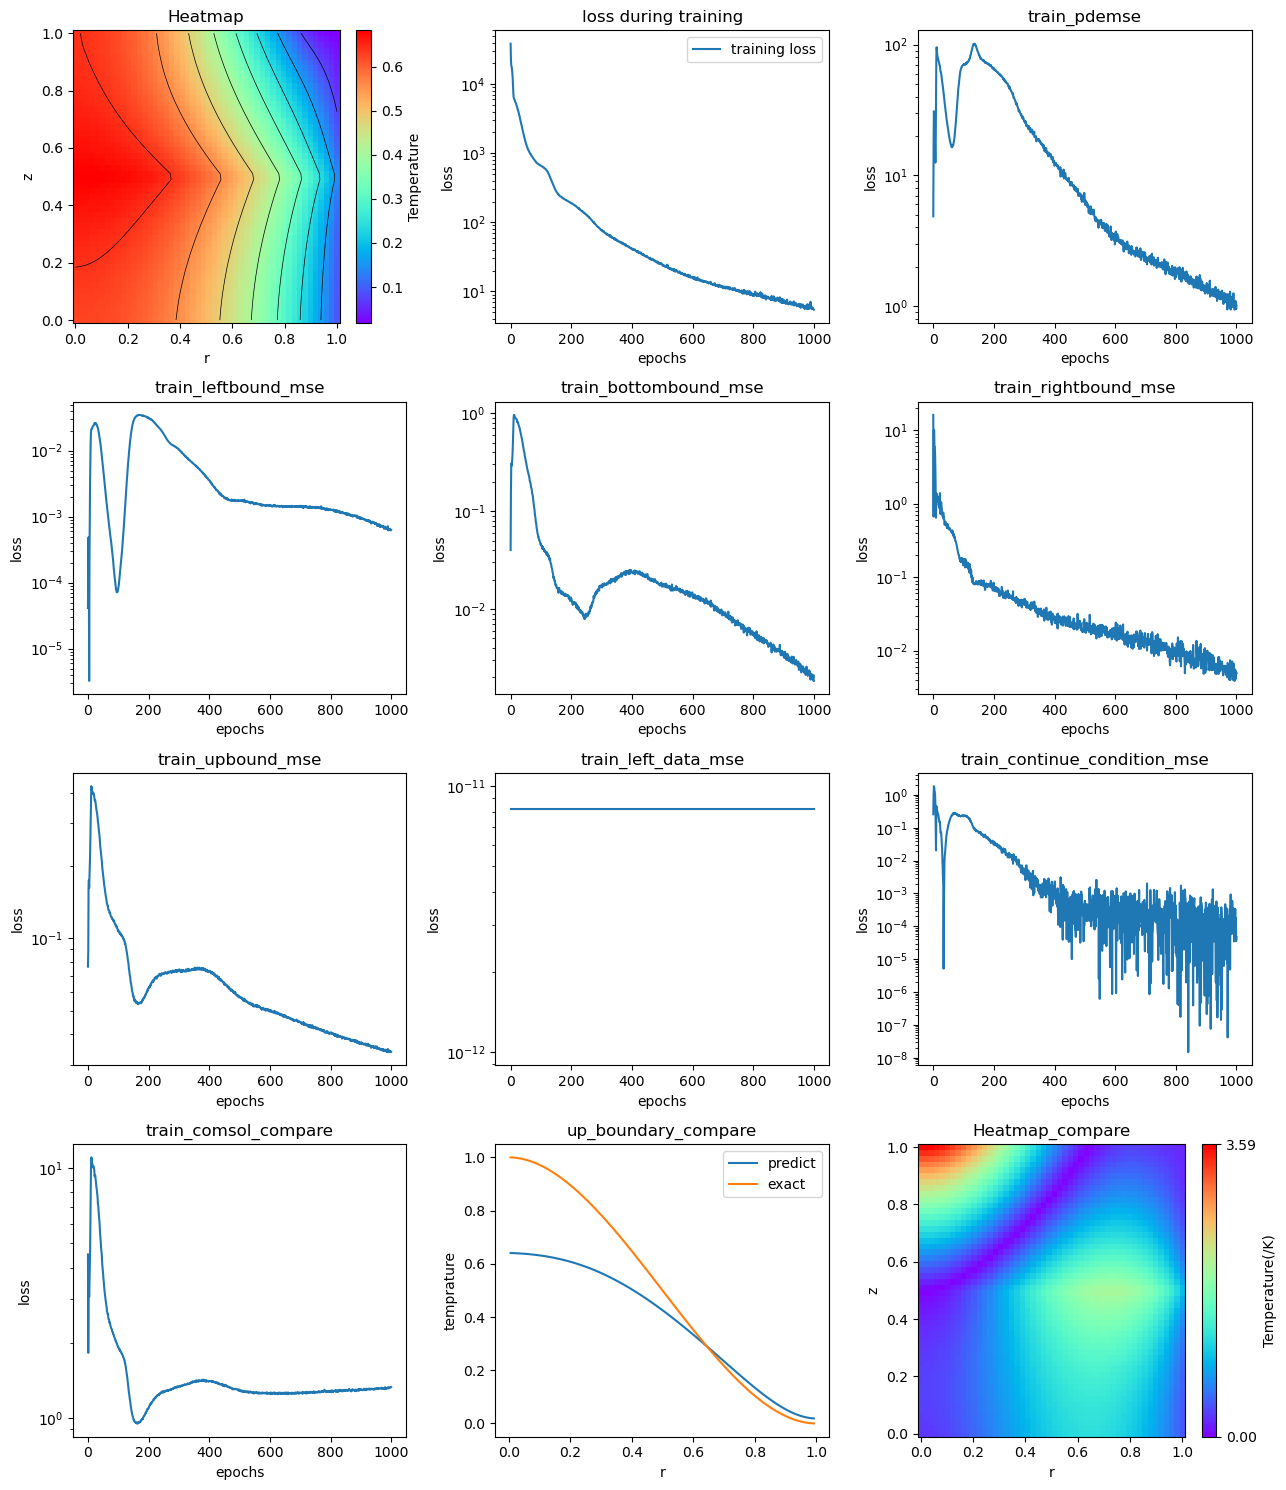

In [5]:
#%matplotlib inline
heat_transfer_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=args.batch_size,
    max_epochs=args.epochs,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 50),
        check_on_y=torch.linspace(0.0, 1.0, 50),
        check_every=args.check_every,
        device=device,
        args=args
    ),
    device=device,
    args=args
)